Mnist DataSet

In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import neighbors
from keras.datasets import mnist
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
import GPy
import GPyOpt
import matplotlib.pyplot as plt

In [19]:
#MNIST データロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train[:1000]
x_test = x_test[:300]
y_train = y_train[:1000]
y_test = y_test[:300]

In [20]:
#KNN
knn = neighbors.KNeighborsClassifier(5, weights = 'distance')
knn.fit(x_train,y_train)

KNeighborsClassifier(weights='distance')

In [21]:
#XGBoost
Xgb = xgb.XGBClassifier()
Xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [22]:
#Random Forest
RF=RandomForestClassifier()
RF.fit(x_train,y_train)

RandomForestClassifier()

In [23]:
#NN
model = Sequential()
model.add(Dense(30, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Y_train = to_categorical(y_train, 10)

hist = model.fit(x_train, Y_train,
                 epochs=30, batch_size=100,verbose=0)

In [24]:
#それぞれの分類精度
from sklearn.metrics import accuracy_score

knn_predict = knn.predict(x_test)
print("KNN")
print(accuracy_score(y_test, knn_predict))

xgb_predict = Xgb.predict(x_test)
print("XGBoost")
print(accuracy_score(y_test, xgb_predict))

RF_predict = RF.predict(x_test)
print("Random Forest")
print(accuracy_score(y_test, RF_predict))

NN_predict = model.predict(x_test, batch_size=1)
NN_predict = np.argmax(NN_predict, axis=1)
print("NN")
print(accuracy_score(y_test, NN_predict))

KNN
0.8533333333333334
XGBoost
0.88
Random Forest
0.8966666666666666
300/300 [==============================] - 0s 1ms/step
NN
0.8866666666666667


In [25]:
def Voting(x_voting,y_voting,k1=1,k2=1,k3=1):
    knn_predict = knn.predict(x_voting)
    xgb_predict = Xgb.predict(x_voting)
    RF_predict = RF.predict(x_voting)
    NN_predict = model.predict(x_voting, batch_size=1)
    NN_predict = np.argmax(NN_predict, axis=1)

    knn_onehot = to_categorical(knn_predict, 10)
    xgb_onehot = to_categorical(xgb_predict, 10)
    RF_onehot = to_categorical(RF_predict, 10)
    NN_onehot = to_categorical(NN_predict, 10)

    voting_result = []
    for i in range(len(x_voting)):
        voting = np.argmax(knn_onehot[i] + k1*xgb_onehot[i] +k2*RF_onehot[i] + k3*NN_onehot[i])
        voting_result.append(voting)
    result = accuracy_score(y_voting, voting_result)
    print(result)
    return result

print("Normal Voting")
_ = Voting(x_test,y_test)

Normal Voting
300/300 [==============================] - 1s 2ms/step
0.9033333333333333


In [26]:
def f(x):
    k = x[:,0]
    kk = x[:,1]
    kkk = x[:,2]
    score = -Voting(x_train,y_train,k,kk,kkk)
    print(-score)
    score = np.array(score)
    return score

bounds = [{'name': 'k', 'type': 'continuous', 'domain': (0.5,1.5)},
          {'name': 'kk', 'type': 'continuous', 'domain': (0.5,1.5)},
          {'name': 'kkk', 'type': 'continuous', 'domain': (0.5,1.5)}]

myBopt = GPyOpt.methods.BayesianOptimization(f, bounds)
myBopt.run_optimization(max_iter=10)

1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 3s 3ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0
1000/1000 [==============================] - 1s 1ms/step
1.0
1.0
1000/1000 [==============================] - 2s 2ms/step
1.0
1.0


best [k1 k2 k3] =
[0.71419211 0.99347617 0.62883166]
Weighted Voting
300/300 [==============================] - 1s 2ms/step
0.91


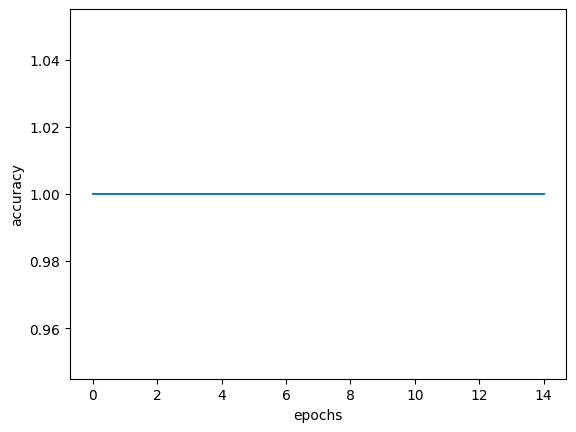

In [15]:
#結果出力
print("best [k1 k2 k3] =")
print(myBopt.x_opt)
print("Weighted Voting")
k_best = myBopt.x_opt
_ = Voting(x_test,y_test,k_best[0],k_best[1],k_best[2])

#探索履歴描画
result_z= -myBopt.Y

plt.figure()
plt.plot(result_z)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [27]:
def f(x):
    k = x[:,0]
    kk = x[:,1]
    kkk = x[:,2]
    x_train_n = x_train + np.random.normal(0, 0.1, (len(x_train), 784))
    score = -Voting(x_train_n,y_train,k,kk,kkk)
    print(-score)
    score = np.array(score)
    return score

bounds = [{'name': 'k', 'type': 'continuous', 'domain': (0.5,1.5)},
          {'name': 'kk', 'type': 'continuous', 'domain': (0.5,1.5)},
          {'name': 'kkk', 'type': 'continuous', 'domain': (0.5,1.5)}]

myBopt = GPyOpt.methods.BayesianOptimization(f, bounds)
myBopt.run_optimization(max_iter=10)

1000/1000 [==============================] - 1s 1ms/step
0.979
0.979
1000/1000 [==============================] - 1s 1ms/step
0.983
0.983
1000/1000 [==============================] - 2s 2ms/step
0.981
0.981
1000/1000 [==============================] - 1s 1ms/step
0.989
0.989
1000/1000 [==============================] - 2s 2ms/step
0.981
0.981
1000/1000 [==============================] - 1s 1ms/step
0.985
0.985
1000/1000 [==============================] - 2s 1ms/step
0.983
0.983
1000/1000 [==============================] - 2s 2ms/step
0.985
0.985
1000/1000 [==============================] - 2s 2ms/step
0.984
0.984
1000/1000 [==============================] - 2s 2ms/step
0.988
0.988
1000/1000 [==============================] - 1s 1ms/step
0.985
0.985
1000/1000 [==============================] - 2s 2ms/step
0.989
0.989
1000/1000 [==============================] - 2s 2ms/step
0.988
0.988
1000/1000 [==============================] - 2s 2ms/step
0.988
0.988
1000/1000 [=======================

best [k1 k2 k3] =
[1.14620968 1.01388553 1.38059552]
Weighted Voting
300/300 [==============================] - 0s 2ms/step
0.9066666666666666


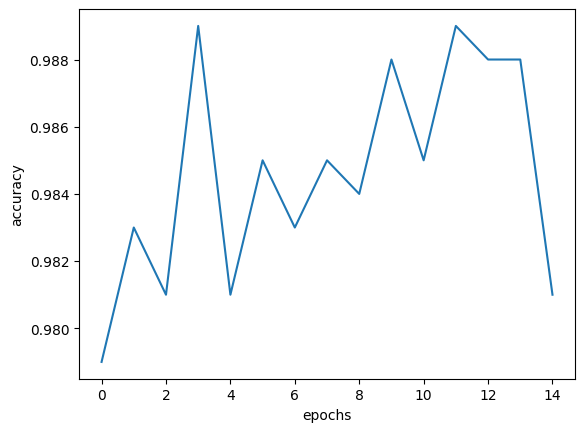

In [28]:
#結果出力
print("best [k1 k2 k3] =")
print(myBopt.x_opt)
print("Weighted Voting")
k_best = myBopt.x_opt
_ = Voting(x_test,y_test,k_best[0],k_best[1],k_best[2])

#探索履歴描画
result_z= -myBopt.Y

plt.figure()
plt.plot(result_z)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()